# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [117]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:04<00:00, 1370.76it/s]


In [23]:
final['Cleaned Text'] = preprocessed_reviews

In [24]:
sample1 = pd.DataFrame()

In [25]:
sample1['Cleaned Text'] =preprocessed_reviews

In [26]:
sample1.tail(3)

,Cleaned Text
87770,trader joe product good quality buy straight t...
87771,coffee supposedly premium tastes watery thin n...
87772,purchased product local store ny kids love qui...


In [27]:
k1 = []

In [28]:
sample1.shape

(87773, 1)

In [29]:
for i in range(0,87773):
    k1.append(len(preprocessed_reviews[i]))

In [30]:
sample1['Length'] = k1

In [31]:
sample1.head(3)

,Cleaned Text,Length
0,dogs loves chicken product china wont buying a...,162
1,dogs love saw pet store tag attached regarding...,72
2,infestation fruitflies literally everywhere fl...,406


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Splitting the Data with feature engineering

In [33]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(sample1,final['Score'].values,test_size=0.3,shuffle=False)

In [34]:
y_train1.shape

(61441,)

In [35]:
X_train1.shape

(61441, 2)

In [120]:
X_test1.shape

(26332, 2)

In [119]:
type(y_test1)

numpy.ndarray

In [118]:
type(X_test1)

pandas.core.frame.DataFrame

In [39]:
X_train1.head(3)

,Cleaned Text,Length
0,dogs loves chicken product china wont buying a...,162
1,dogs love saw pet store tag attached regarding...,72
2,infestation fruitflies literally everywhere fl...,406


In [40]:
X_test1.head(3)

,Cleaned Text,Length
61441,used treat training reward dog loves easy brea...,66
61442,much fun watching puppies asking chicken treat...,134
61443,little shih tzu absolutely loves cesar softies...,181


In [41]:
X_trainbow = pd.DataFrame()

In [42]:
X_trainbow['Cleaned Text'] = X_train1['Cleaned Text'] 

In [43]:
X_trainbow.head(3)

,Cleaned Text
0,dogs loves chicken product china wont buying a...
1,dogs love saw pet store tag attached regarding...
2,infestation fruitflies literally everywhere fl...


In [44]:
X_testbow = pd.DataFrame()

In [45]:
X_testbow['Cleaned Text'] = X_test1['Cleaned Text']

In [46]:
X_testbow.head(3)

,Cleaned Text
61441,used treat training reward dog loves easy brea...
61442,much fun watching puppies asking chicken treat...
61443,little shih tzu absolutely loves cesar softies...


# BAG OF WORDS WITH FEATURE ENGINEERING 

In [47]:
X_trainbow.shape

(61441, 1)

In [48]:
X_testbow.shape

(26332, 1)

In [49]:
count_vect = CountVectorizer() 
a1 = count_vect.fit_transform(X_trainbow['Cleaned Text'].values)
b1 = count_vect.transform(X_testbow['Cleaned Text'])

In [50]:
print("the type of count vectorizer :",type(a1))
print("the shape of out text BOW vectorizer : ",a1.get_shape())
print("the number of unique words :", a1.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (61441, 46008)
the number of unique words : 46008


# ADDING LENGTH OF REVIEWS AS ONE FEATURE 

In [51]:
a1 = preprocessing.normalize(a1)

In [52]:
from scipy import sparse

In [53]:
from scipy.sparse import csr_matrix

In [54]:
a2 = sparse.csr_matrix(X_train1['Length'].values)

In [55]:
a2 = preprocessing.normalize(a2)

In [56]:
a1

<61441x46008 sparse matrix of type '<class 'numpy.float64'>'
	with 2002037 stored elements in Compressed Sparse Row format>

In [57]:
a2.T

<61441x1 sparse matrix of type '<class 'numpy.float64'>'
	with 61271 stored elements in Compressed Sparse Column format>

In [58]:
a3 = sparse.hstack([a1, a2.T])

In [59]:
a3.shape

(61441, 46009)

In [60]:
b1 = preprocessing.normalize(b1)

In [61]:
b2 = sparse.csr_matrix(X_test1['Length'].values)

In [62]:
b2 = preprocessing.normalize(b2)

In [63]:
b1

<26332x46008 sparse matrix of type '<class 'numpy.float64'>'
	with 888781 stored elements in Compressed Sparse Row format>

In [64]:
b2.T

<26332x1 sparse matrix of type '<class 'numpy.float64'>'
	with 26286 stored elements in Compressed Sparse Column format>

In [65]:
b3 = sparse.hstack([b1, b2.T])

# Multinomial NB for BOW with Feature Engineering 

In [66]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score
from sklearn.naive_bayes import MultinomialNB

# Finding Optimal Alpha 

In [67]:
from sklearn.metrics import roc_auc_score

In [68]:
# Starting with minimum alpha = 10^-6 to 10^6

In [80]:
alph1 = []

In [81]:
i = 0.00001
while(i<100000):
    alph1.append(np.round(i,6))
    i *= 10

In [83]:
len(alph1)

10

In [71]:
from sklearn.model_selection import GridSearchCV

In [72]:
nb=MultinomialNB()
parameters={'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}
clf=GridSearchCV(nb,parameters,cv=10,error_score='roc')
clf.fit(a3,y_train1)
train_auc=clf.cv_results_['mean_train_score']
cv_auc=clf.cv_results_['mean_test_score']

In [73]:
print(train_auc)
print(cv_auc)

[0.91870068 0.91672408 0.91314522 0.90690256 0.8871528  0.8439804
 0.84288993 0.84288993 0.84288993 0.84288993]
[0.86707573 0.86961475 0.87291874 0.87479045 0.86881724 0.8433782
 0.84288993 0.84288993 0.84288993 0.84288993]


In [73]:
# Using 10 fold cross validation

In [74]:
#for i in range(0,26):
#    model = MultinomialNB(alpha = alph[i])
#    model.fit(a3,y_train1)
#    scores = cross_val_score(model, a3 , y_train1, cv= 10, scoring='accuracy', n_jobs=-1)
#    cv_scores2.append(scores.mean()) 
    #auc2.append(roc_auc_score(y_test1,predictions))

In [85]:
import math
from math import log

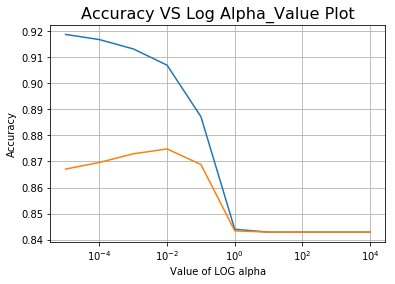



 Alpha values :
 [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]

Accuracy for each alpha value is :
  [0.9187  0.91672 0.91315 0.9069  0.88715 0.84398 0.84289 0.84289 0.84289
 0.84289]

Accuracy for each alpha value is :
  [0.86708 0.86961 0.87292 0.87479 0.86882 0.84338 0.84289 0.84289 0.84289
 0.84289]


In [104]:
# plot accuracy vs alpha 
plt.plot(alph1,train_auc)
plt.plot(alph1,cv_auc)
plt.xlabel('Value of LOG alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy VS Log Alpha_Value Plot',size=16)
plt.xscale('log')
plt.grid()
plt.show()
print("\n\n Alpha values :\n", alph1)
print("\nAccuracy for each alpha value is :\n ", np.round(train_auc,5))
print("\nAccuracy for each alpha value is :\n ", np.round(cv_auc,5))

# Observations for  getting the optimal alpha 

1) We have found that the optimal alpha occurs at 0.01 as the cv accuracy is high at that point.

In [106]:
optimalalpha2_bow = 0.01
auc_bow = max(cv_auc)

In [110]:
from IPython.display import HTML, display
import tabulate
table = [["Vectorizer","Model","Hyperparameter","AUC"],
         ["BOW", "10 FOLD CV ", optimalalpha2_bow, np.round(auc_bow,2) ]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Vectorizer,Model,Hyperparameter,AUC
BOW,10 FOLD CV,0.01,0.87


In [ ]:
# after you found the best hyper parameter, you need to train your model with it, 
#and find the AUC on test data and plot the ROC curve on both train and test. 
# Along with plotting ROC curve, you need to print the confusion matrix with predicted 
#and original labels of test data points. Please visualize your confusion matrices using seaborn heatmaps. 

# Training the model with the best hyper parameter 

In [123]:
om_bow = MultinomialNB(alpha = optimalalpha2_bow)
# fitting the model and predicting the responses
om_bow.fit(a3, y_train1)
ompredictions_bow  = om_bow.predict(b3)

In [131]:
len(ompredictions_bow)

26332

In [134]:
len(y_test1)

26332

In [139]:
probs = om_bow.predict_proba(b3)

In [146]:
probs1 = om_bow.predict_proba(a3)

In [147]:
len(probs1)

61441

In [140]:
len(probs)

26332

In [141]:
probs = probs[:, 1]

In [151]:
probs1 = probs1[:, -1]

# FEATURE IMPORTANCE  FOR BOW 

In [156]:
featu_imp = om_bow.feature_log_prob_
featu_neg = featu_imp[0]
featu_pos = featu_imp[1]

In [157]:
# Getting all feature names
feature_names = count_vect.get_feature_names()

# Sorting 'negative_features' and 'positive_features' in descending order using argsort() function
sorted_negative_features = np.argsort(featu_neg)[::-1]
sorted_positive_features = np.argsort(featu_pos)[::-1]

print(" TOP 10 IMPORTANT FEATURES FOR NEGATIVE CLASS WITH PROBABILITIES  : \n")
for i in list(sorted_negative_features[0:10]):
    print("%s\t \t%f  "%(feature_names[i],featu_neg[i]))
    
print("\n TOP 10 IMPORTANT FEATURES FOR POSITIVE  CLASS WITH PROBABILITIES  : \n")
for i in list(sorted_positive_features[0:10]):
    print("%s\t \t%f  "%(feature_names[i],featu_pos[i]))

 TOP 10 IMPORTANT FEATURES FOR NEGATIVE CLASS WITH PROBABILITIES  : 

not	 	-3.227348  
like	 	-4.371892  
product	 	-4.598462  
taste	 	-4.636533  
would	 	-4.663952  
one	 	-4.867049  
good	 	-5.020253  
no	 	-5.144973  
flavor	 	-5.160923  
food	 	-5.270670  

 TOP 10 IMPORTANT FEATURES FOR POSITIVE  CLASS WITH PROBABILITIES  : 

not	 	-3.767790  
great	 	-4.476389  
good	 	-4.516463  
like	 	-4.564044  
love	 	-4.820289  
one	 	-4.907343  
product	 	-4.932354  
tea	 	-4.949877  
taste	 	-4.953129  
flavor	 	-5.035632  


# PERFORMANCE MEASURMENTS 

In [158]:
precision_bow = precision_score(y_test1, ompredictions_bow, pos_label = 1) 
recall_bow = recall_score(y_test1, ompredictions_bow, pos_label = 1) 
f1score_bow = f1_score(y_test1, ompredictions_bow, pos_label = 1) 

In [159]:
print('\nThe Test Precision for optimal alpha for MNB (BOW)  = %.5f is %f' % (optimalalpha2_bow, precision_bow))
print('\nThe Test Recall for optimal alpha for MNB (BOW)  = %.5f is %f' % (optimalalpha2_bow, recall_bow))
print('\nThe Test F1-Score for optimal alpha for MNB (BOW)= %.5f is %f' % (optimalalpha2_bow, f1score_bow))


The Test Precision for optimal alpha for MNB (BOW)  = 0.01000 is 0.860863

The Test Recall for optimal alpha for MNB (BOW)  = 0.01000 is 0.996010

The Test F1-Score for optimal alpha for MNB (BOW)= 0.01000 is 0.923519


# CONFUSION MATRIX 

In [132]:
# Reference Links 
# https://datatofish.com/confusion-matrix-python/

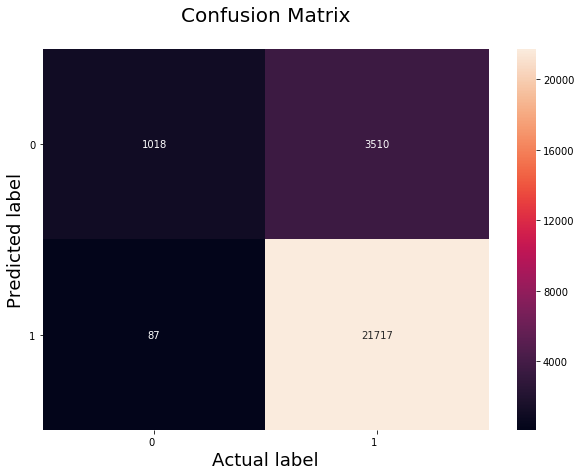

In [160]:
# Code for drawing seaborn heatmaps
class_names = [ 0,1]
df_heatmap = pd.DataFrame(confusion_matrix(y_test1, ompredictions_bow), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)#
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
plt.ylabel('Predicted label',size=18)
plt.xlabel('Actual label',size=18)
plt.title("Confusion Matrix\n",size=20)
plt.show()

In [161]:
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test1, ompredictions_bow).ravel()
TPR = TruePos/(FalseNeg + TruePos)
FPR = FalsePos/(TrueNeg + FalsePos)
TNR = TrueNeg/(TrueNeg + FalsePos)
FNR = FalseNeg/(FalseNeg + TruePos)

In [162]:
print("TPR of the Multinomial naive Bayes classifier (BOW) for alpha = %.6f is :  %f" % (optimalalpha2_bow,TPR))
print("FPR of the Multinomial naive Bayes classifier (BOW) for alpha = %.6f is :  %f" % (optimalalpha2_bow,FPR))
print("TNR of the Multinomial naive Bayes classifier (BOW) for alpha = %.6f is :  %f" % (optimalalpha2_bow,TNR))
print("FNR of the Multinomial naive Bayes classifier (BOW) for alpha = %.6f is :  %f" % (optimalalpha2_bow,FNR))

TPR of the Multinomial naive Bayes classifier (BOW) for alpha = 0.010000 is :  0.860863
FPR of the Multinomial naive Bayes classifier (BOW) for alpha = 0.010000 is :  0.078733
TNR of the Multinomial naive Bayes classifier (BOW) for alpha = 0.010000 is :  0.921267
FNR of the Multinomial naive Bayes classifier (BOW) for alpha = 0.010000 is :  0.139137


# PLOTTING THE ROC CURVE  (BOW) ---- > FOR BOTH TRAIN AND TEST DATA 

In [143]:
len(y_train1)

61441

In [149]:
len(probs1)

61441

In [155]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()

for i in range(26331):
    fpr[i], tpr[i], _ = roc_curve(y_test1,probs)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
for i in range(61441):
    fpr1[i], tpr1[i], _ = roc_curve(y_train1,probs1)
    roc_auc1[i] = auc(fpr1[i], tpr1[i])    


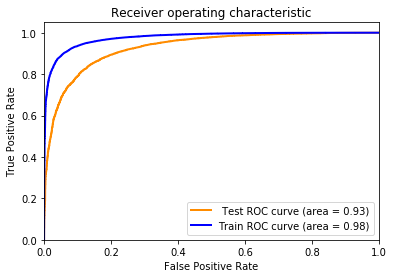

In [164]:
#print(roc_auc_score(y_test1,ompredictions_bow))
plt.figure()
#plt.plot(fpr[1], tpr[1])
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label=' Test ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot(fpr1[0], tpr1[0], color='blue',lw=lw, label='Train ROC curve (area = %0.2f)' % roc_auc1[0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic')
plt.show()

# Observations 
1) We observe that AUC for test data is 0.93 and train data is 0.98 which implies that the model is very good.

# TFIDF WITH FEATURE ENGINEERING 

In [166]:
tf_idf_vect = TfidfVectorizer(min_df=10)
c1 = tf_idf_vect.fit_transform(X_trainbow['Cleaned Text'].values)
d1 = tf_idf_vect.transform(X_testbow['Cleaned Text'])
print("the type of count vectorizer :",type(c1))
print("the shape of out text TFIDF vectorizer : ",c1.get_shape())
print("the number of unique words :", c1.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (61441, 9723)
the number of unique words : 9723


In [167]:
c1 = preprocessing.normalize(c1)

In [168]:
c2 = sparse.csr_matrix(X_train1['Length'].values)
c2 = preprocessing.normalize(c2)

In [169]:
c1

<61441x9723 sparse matrix of type '<class 'numpy.float64'>'
	with 1925265 stored elements in Compressed Sparse Row format>

In [170]:
c2.T

<61441x1 sparse matrix of type '<class 'numpy.float64'>'
	with 61271 stored elements in Compressed Sparse Column format>

In [171]:
c3 = sparse.hstack([c1, c2.T])

In [172]:
d1 = preprocessing.normalize(d1)
d2 = sparse.csr_matrix(X_test1['Length'].values)
d2 = preprocessing.normalize(d2)
d3 = sparse.hstack([d1, d2.T])

# FINDING OPTIMAL ALPHA FOR TFIDF

In [176]:
alph2 =[]
i = 0.00001
while(i<100000):
    alph2.append(np.round(i,6))
    i *= 10

In [179]:
nb=MultinomialNB()
parameters={'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}
clf=GridSearchCV(nb,parameters,cv=10,error_score='roc')
clf.fit(c3,y_train1)
train_auc_tfidf=clf.cv_results_['mean_train_score']
cv_auc_tfidf=clf.cv_results_['mean_test_score']

In [180]:
print(train_auc_tfidf)
print(cv_auc_tfidf)

[0.89602491 0.89598693 0.89594172 0.89577354 0.89434851 0.87992455
 0.84316481 0.84288993 0.84288993 0.84288993]
[0.87610879 0.87648313 0.87736202 0.87833857 0.87936394 0.87098192
 0.84306896 0.84288993 0.84288993 0.84288993]


# PLOTTING AUC FOR TRAIN AND CV DATA 

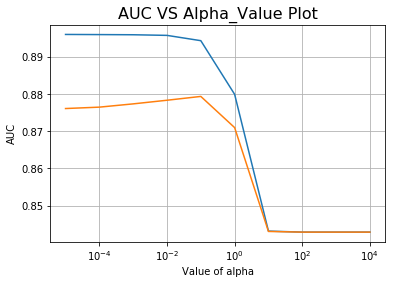



 Alpha values :
 [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]

 AUC for each alpha value is :
  [0.89602 0.89599 0.89594 0.89577 0.89435 0.87992 0.84316 0.84289 0.84289
 0.84289]

 AUC for each alpha value is :
  [0.87611 0.87648 0.87736 0.87834 0.87936 0.87098 0.84307 0.84289 0.84289
 0.84289]


In [181]:
plt.plot(alph2,train_auc_tfidf)
plt.plot(alph2,cv_auc_tfidf)
plt.xlabel('Value of alpha',size=10)
plt.ylabel('AUC',size=10)
plt.title('AUC VS Alpha_Value Plot',size=16)
plt.xscale('log')
plt.grid()
plt.show()
print("\n\n Alpha values :\n", alph2)
print("\n AUC for each alpha value is :\n ", np.round(train_auc_tfidf,5))
print("\n AUC for each alpha value is :\n ", np.round(cv_auc_tfidf,5))

# Finding Optimal Alpha  for TFIDF 

In [182]:
auc_tfidf = max(cv_auc_tfidf)

In [183]:
auc_tfidf

0.8793639426441627

In [185]:
optimalalpha2_tfidf = 0.1
om_tfidf = MultinomialNB(alpha = optimalalpha2_tfidf)
# fitting the model and predicting the responses
om_tfidf.fit(c3, y_train1)
ompredictions_tfidf  = om_tfidf.predict(d3)

In [186]:
probs2 = om_tfidf.predict_proba(c3)
probs3 = om_tfidf.predict_proba(d3)
probs2= probs2[:, 1]
probs3 = probs3[:, 1]

# Training the model with the best hyper parameter for TFIDF 

In [187]:
om_tfidf = MultinomialNB(alpha = optimalalpha2_tfidf)
# fitting the model and predicting the responses
om_tfidf.fit(c3, y_train1)
ompredictions_tfidf  = om_tfidf.predict(d3)

# Checking the test accuracy
#tesacc_tfidf   = accuracy_score(y_test1, ompredictions_tfidf) * 100
#res_tesaccuracy.append(tesacc_tfidf)

In [188]:
len(ompredictions_tfidf)

26332

# Feature  Importance for TFIDF 

In [189]:
featu_imp = om_tfidf.feature_log_prob_
featu_neg = featu_imp[0]
featu_pos = featu_imp[1]
feature_names = tf_idf_vect.get_feature_names()
sorted_negative_features = np.argsort(featu_neg)[::-1]
sorted_positive_features = np.argsort(featu_pos)[::-1]

In [190]:
print(" TOP 10 IMPORTANT FEATURES FOR NEGATIVE CLASS WITH PROBABILITIES  : \n")
for i in list(sorted_negative_features[0:10]):
    print("%s\t \t%f  "%(feature_names[i],featu_neg[i]))
    
print("\n TOP 10 IMPORTANT FEATURES FOR POSITIVE  CLASS WITH PROBABILITIES  : \n")
for i in list(sorted_positive_features[0:10]):
    print("%s\t \t%f  "%(feature_names[i],featu_pos[i]))

 TOP 10 IMPORTANT FEATURES FOR NEGATIVE CLASS WITH PROBABILITIES  : 

not	 	-4.271665  
like	 	-5.090397  
product	 	-5.183074  
taste	 	-5.209515  
would	 	-5.237904  
one	 	-5.494873  
no	 	-5.652274  
food	 	-5.679749  
flavor	 	-5.684355  
tea	 	-5.700934  

 TOP 10 IMPORTANT FEATURES FOR POSITIVE  CLASS WITH PROBABILITIES  : 

not	 	-4.798602  
great	 	-5.106543  
good	 	-5.176237  
tea	 	-5.234596  
like	 	-5.268421  
love	 	-5.339580  
product	 	-5.472229  
one	 	-5.510608  
coffee	 	-5.514886  
taste	 	-5.523108  


# PERFORMANCE MEASURMENTS FOR TFIDF 

In [191]:
precision_tfidf = precision_score(y_test1, ompredictions_tfidf, pos_label = 1) 
recall_tfidf = recall_score(y_test1, ompredictions_tfidf, pos_label = 1) 
f1score_tfidf = f1_score(y_test1, ompredictions_tfidf, pos_label = 1) 

In [192]:
print('\nThe Test Precision for optimal alpha for MNB (TFIDF)  = %.5f is %f' % (optimalalpha2_tfidf, precision_tfidf))
print('\nThe Test Recall for optimal alpha for MNB (TFIDF)  = %.5f is %f' % (optimalalpha2_tfidf, recall_tfidf))
print('\nThe Test F1-Score for optimal alpha for MNB (TFIDF)= %.5f is %f' % (optimalalpha2_tfidf, f1score_tfidf))


The Test Precision for optimal alpha for MNB (TFIDF)  = 0.10000 is 0.869175

The Test Recall for optimal alpha for MNB (TFIDF)  = 0.10000 is 0.994863

The Test F1-Score for optimal alpha for MNB (TFIDF)= 0.10000 is 0.927782


# CONFUSION MATRIX (TFIDF)

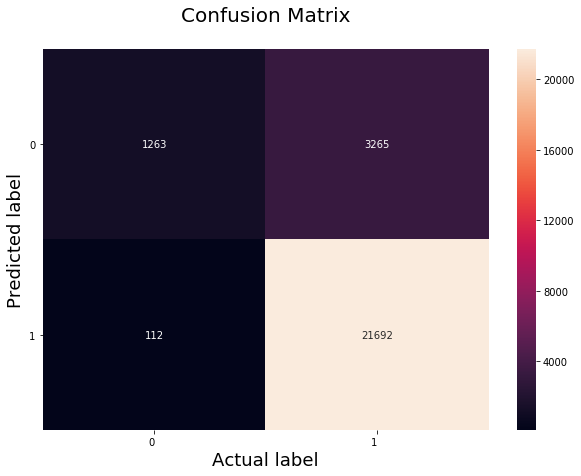

In [193]:
# Code for drawing seaborn heatmaps
class_names = [ 0,1]
df_heatmap = pd.DataFrame(confusion_matrix(y_test1, ompredictions_tfidf), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)#
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
plt.ylabel('Predicted label',size=18)
plt.xlabel('Actual label',size=18)
plt.title("Confusion Matrix\n",size=20)
plt.show()

In [194]:
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test1, ompredictions_tfidf).ravel()
TPR = TruePos/(FalseNeg + TruePos)
FPR = FalsePos/(TrueNeg + FalsePos)
TNR = TrueNeg/(TrueNeg + FalsePos)
FNR = FalseNeg/(FalseNeg + TruePos)
print("TPR of the Multinomial naive Bayes classifier (TFIDF) for alpha = %.6f is :  %f" % (optimalalpha2_tfidf,TPR))
print("FPR of the Multinomial naive Bayes classifier (TFIDF) for alpha = %.6f is :  %f" % (optimalalpha2_tfidf,FPR))
print("TNR of the Multinomial naive Bayes classifier (TFIDF) for alpha = %.6f is :  %f" % (optimalalpha2_tfidf,TNR))
print("FNR of the Multinomial naive Bayes classifier (TFIDF) for alpha = %.6f is :  %f" % (optimalalpha2_tfidf,FNR))

TPR of the Multinomial naive Bayes classifier (TFIDF) for alpha = 0.100000 is :  0.869175
FPR of the Multinomial naive Bayes classifier (TFIDF) for alpha = 0.100000 is :  0.081455
TNR of the Multinomial naive Bayes classifier (TFIDF) for alpha = 0.100000 is :  0.918545
FNR of the Multinomial naive Bayes classifier (TFIDF) for alpha = 0.100000 is :  0.130825


# ROC CURVE FOR TFIDF 

In [196]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()

for i in range(26331):
    fpr[i], tpr[i], _ = roc_curve(y_test1,probs3)
    roc_auc[i] = auc(fpr[i], tpr[i])

In [197]:
from tqdm import tqdm
for i in range(61441):
    fpr1[i], tpr1[i], _ = roc_curve(y_train1,probs2)
    roc_auc1[i] = auc(fpr1[i], tpr1[i])    

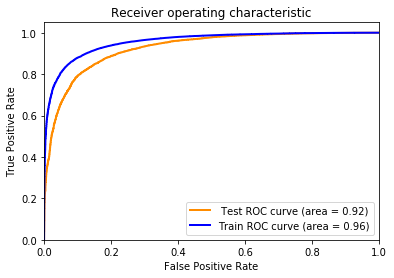

In [198]:
#print(roc_auc_score(y_test1,ompredictions_bow))
plt.figure()
#plt.plot(fpr[1], tpr[1])
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label=' Test ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot(fpr1[0], tpr1[0], color='blue',lw=lw, label='Train ROC curve (area = %0.2f)' % roc_auc1[0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic')
plt.show()

# CONCLUSION 

In [199]:
res = pd.DataFrame()

In [200]:
model_names = ["Multinomial NB for BoW", "Multinomial NB for TFIDF"]

In [201]:
res['Model Name'] = model_names

In [202]:
optimal_alpha = [optimalalpha2_bow , optimalalpha2_tfidf]
precision  = [precision_bow, precision_tfidf]
recall  = [recall_bow, recall_tfidf]
f1score  = [f1score_bow, f1score_tfidf]


In [203]:
auc = [auc_bow,auc_tfidf]

In [204]:
res['Optimal Alpha'] =  optimal_alpha 
res['Precision'] = precision 
res['Recall'] = recall 
res['F1 score'] = f1score 
res['AUC'] = auc

In [205]:
res

,Model Name,Optimal Alpha,Precision,Recall,F1 score,AUC
0,Multinomial NB for BoW,0.01,0.860863,0.996010,0.923519,0.874790
1,Multinomial NB for TFIDF,0.10,0.869175,0.994863,0.927782,0.879364


In [144]:
import tabulatehelper as th

# DISPLAYING THE RESULTS IN TABULAR FORMAT 

In [145]:
print(th.md_table(res, formats={-1: 'c'}))

| Model Name               |   Optimal Alpha |   Precision |   Recall |   F1 score |   Test Accuracy |      AUC |
|:-------------------------|----------------:|------------:|---------:|-----------:|----------------:|:--------:|
| Multinomial NB for BoW   |        0.019683 |    0.860704 | 0.996102 |   0.923466 |         86.3284 | 0.60991  |
| Multinomial NB for TFIDF |        0.059049 |    0.869234 | 0.994772 |   0.927776 |         87.1753 | 0.637072 |


# Final Observations :


1) The same has been the case with Area under the curve. In TFIDF the AUC has been higher when compared to BOW for cv data.   However for the test data auc has been more for BOW rather than for TFIDF 

2) As suggested I have added length of preprocessed reviews as one more feature which has been contributed for more accuracy. 
   However if i would have used more features like length of common words or something else, the results would have been 
   different( my assumption)

3) F1 score and precision has been more for TFIDF too when compared to BOW. 

4) Recall score has been less for TFIDF when compared to BOW. (IMPLIES => Number of Actual Positives TFIDF MODEL has 
    captured through labeling it as true Positive has been slightly less when compared to BOW. ) 

# References 

I have referred many links. However part of my code has been inspired from the following links 

1) Applied AI Course  - https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/

2) GITHUB - PushpendraSinghChauhan (#https://github.com/PushpendraSinghChauhan/Amazon-Fine-FoodReviews/blob/master/Apply%20Naive%20Bayes%20on%20Amazon%20Fine%20Food%20Reviews.ipynb)

3) SKLEARN 

4) STACK OVERFLOW  - MANY 

# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

In [ ]:
final_counts

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

# [6] Conclusions

In [0]:
# Please compare all your models using Prettytable library